In [ ]:
import pandas as pd
import pyproj

# Charger le fichier CSV
file_path = '../data/raw/TMJA2019.csv'
try:
    df = pd.read_csv(file_path, sep=';', encoding='utf-8')  # Séparateur français
except Exception as e:
    print(f"Erreur lors de la lecture : {e}")
    df = pd.read_csv(file_path, sep=None, engine='python')

# Définir les systèmes de coordonnées
source_crs = pyproj.CRS('EPSG:2154')  # Lambert 93
target_crs = pyproj.CRS('EPSG:4326')  # WGS84 (lat, lon)
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Fonction pour nettoyer, convertir et transformer les coordonnées
def convert_to_geopoint(x, y):
    if pd.isna(x) or pd.isna(y):
        return None
    try:
        x_str = str(x).replace(',', '.').strip().strip('"').strip("'")
        y_str = str(y).replace(',', '.').strip().strip('"').strip("'")
        x_clean = float(x_str)
        y_clean = float(y_str)
        lon, lat = transformer.transform(x_clean, y_clean)
        return f"POINT({lon:.6f} {lat:.6f})"  # ✅ Sans virgule, format WKT valide
    except Exception as e:
        print(f"Erreur de conversion: x = {x}, y = {y} → {e}")
        return None

# Créer les nouvelles colonnes geopoint
print("Conversion des coordonnées de départ...")
df['geopoint_depart'] = df.apply(lambda row: convert_to_geopoint(row['xD'], row['yD']), axis=1)

print("Conversion des coordonnées de fin...")
df['geopoint_fin'] = df.apply(lambda row: convert_to_geopoint(row['xF'], row['yF']), axis=1)

# Statistiques sur la conversion
depart_success = df['geopoint_depart'].notna().sum()
fin_success = df['geopoint_fin'].notna().sum()
total_rows = len(df)
print(f"\nRésultats de la conversion :")
print(f"- Points de départ convertis : {depart_success}/{total_rows}")
print(f"- Points de fin convertis : {fin_success}/{total_rows}")

# Afficher un aperçu des conversions réussies
print("\nAperçu des conversions réussies :")
sample_df = df[df['geopoint_depart'].notna() | df['geopoint_fin'].notna()].head()
if not sample_df.empty:
    print(sample_df[['xD', 'yD', 'geopoint_depart', 'xF', 'yF', 'geopoint_fin']])
else:
    print("Aucune conversion réussie trouvée")

# Sauvegarder le DataFrame
output_file_path = '../data/clean/TMJA2019_with_geopoint.csv'
df.to_csv(output_file_path, index=False)
print(f"\nFichier sauvegardé : {output_file_path}")


Conversion des coordonnées de départ...
Conversion des coordonnées de fin...

Résultats de la conversion :
- Points de départ convertis : 4695/4695
- Points de fin convertis : 4695/4695

Aperçu des conversions réussies :
          xD          yD            geopoint_depart         xF          yF  \
0  511656,78  6204078,36  POINT(0.695459 42.911382)  511698,51  6204063,93   
1  511367,22  6204210,06  POINT(0.691871 42.912490)  511880,76   6203732,4   
2  844036,84  6510806,45  POINT(4.850575 45.681629)  849346,89  6509342,34   
3   846831,3  6522372,16  POINT(4.890020 45.785151)  843537,87   6512429,8   
4  844982,46  6522772,27  POINT(4.866352 45.789149)   846831,3  6522372,16   

                geopoint_fin  
0  POINT(0.695975 42.911263)  
1  POINT(0.698322 42.908331)  
2  POINT(4.918315 45.667307)  
3  POINT(4.844653 45.696348)  
4  POINT(4.890020 45.785151)  

Fichier sauvegardé : ../data/TMJA2019_with_geopoint.csv


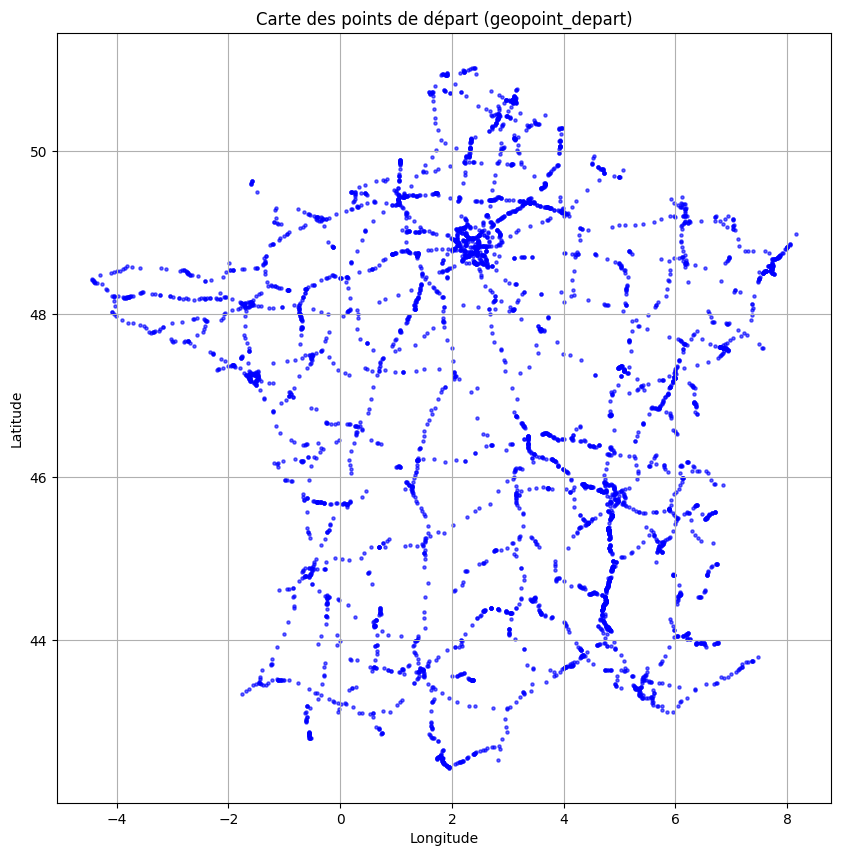

In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# Charger le fichier CSV avec geopoints
df = pd.read_csv('../data/TMJA2019_with_geopoint.csv')

# Convertir les champs geopoint WKT en géométrie Shapely
df['geometry'] = df['geopoint_depart'].dropna().apply(wkt.loads)

# Créer un GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')  # WGS84

# Afficher la carte
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.6)

ax.set_title("Carte des points de départ (geopoint_depart)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()
